In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import read_csv
import datetime
import seaborn as sns
from sklearn.svm import SVC
import time


from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

from statsmodels.tools.eval_measures import rmse


import warnings
warnings.filterwarnings('ignore')

### Import a Dataset

In [199]:
series = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


In [200]:
data= series.loc['Z8RsBpxhnkebK5fvahVCmfV7icO2']

In [201]:
data.head()

,time,valueHR,valuesteps,WkHR,WkCal,WkSteps,sec,sugarValue,cal,carbs,fat,fiber,protein,sodium
uid,,,,,,,,,,,,,,
Z8RsBpxhnkebK5fvahVCmfV7icO2,2019-12-16 00:15:00,72.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z8RsBpxhnkebK5fvahVCmfV7icO2,2019-12-16 00:30:00,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z8RsBpxhnkebK5fvahVCmfV7icO2,2019-12-16 00:45:00,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z8RsBpxhnkebK5fvahVCmfV7icO2,2019-12-16 01:00:00,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z8RsBpxhnkebK5fvahVCmfV7icO2,2019-12-16 01:15:00,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
data =data.reset_index()

In [203]:
data = data.drop(['uid','time'], axis=1)

In [204]:
data = data.fillna(0)

In [205]:
data = data.drop(data[data.sugarValue < 1].index, inplace=False)

In [206]:
float_col = data.select_dtypes(include=['float64']) # This will select float columns only
#list(float_col.columns.values)
for col in float_col.columns.values:
        data[col] = data[col].astype('int64')

### The final dataset will be: 

In [207]:
data

,valueHR,valuesteps,WkHR,WkCal,WkSteps,sec,sugarValue,cal,carbs,fat,fiber,protein,sodium
823,77,0,0,0,0,0,90,0,0,0,0,0,0
824,75,49,0,0,0,0,90,0,0,0,0,0,0
825,73,71,0,0,0,0,86,0,0,0,0,0,0
826,89,650,0,0,0,0,82,0,0,0,0,0,0
827,97,393,0,0,0,0,79,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094,0,0,0,0,0,0,102,0,0,0,0,0,0
2095,0,0,0,0,0,0,102,0,0,0,0,0,0
2096,0,0,0,0,0,0,108,0,0,0,0,0,0
2097,0,0,0,0,0,0,105,0,0,0,0,0,0


### Let’s create our model. We are trying to predict a patient diabetes value. This coincides with the ‘sugarValue’ column, which will be our independent variable. We’ll use all the other columns as features for our model.

In [208]:
X = data.drop('sugarValue', axis=1)
y = data['sugarValue']

### We’ll use train-test-split to split the data into training data and testing data, and create a random forest model.


### Create a windows, compute the predictions and calculate the MAE and RMSE for each window. Save the values in a dataset. 


In [209]:
start_time = time.time()

window = pd.DataFrame(columns=['Current train', 'Current test', 'RMSE', 'Interval'])
list = [12,24,48,96,144] 


for z in list:
    for v in range(4):
        n=z ##3h
        
        interval = (v+1)*15
        windo= n/4
        
        print(interval, int(round(windo)))
        
        
        
        for x in range(len(data)-n-v):

        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1)

            X_train = X.iloc[x:n]
            X_test = X.iloc[n:n+v+1]
            y_train = y.iloc[x:n]
            y_test = y.iloc[n:n+v+1]

            svclassifier = SVC(kernel='linear')
            svclassifier.fit(X_train, y_train)

            y_pred = svclassifier.predict(X_test)

            

            window = window.append({'Current train': "From: "+str(y_train.index[0]) +" to: " + str(y_train.index[-1]) , 
                                    'Current test':"From: "+str(y_test.index[0]) +" to: " + str(y_test.index[-1]), 
                                    'RMSE': rmse(y_test, y_pred),
                                   'Interval': str(interval) + "Min" + " "+ str(int(round(windo)))+ "PSW" },ignore_index=True)
            n=n+1
        v= v+1
    
print("--- %s Seconds for computation ---" % (time.time() - start_time))
 


15 3
30 3
45 3
60 3
15 6
30 6
45 6
60 6
15 12
30 12
45 12
60 12
15 24
30 24
45 24
60 24
15 36
30 36
45 36
60 36
--- 71737.06509923935 Seconds for computation ---


### The dataset will show :

#### - Current train (the current window values) 
#### - Current test (the predicted values)
#### - RMSE (root mean square error)
#### - Predictive horizons (PHs) for each window.

In [210]:
window

,Current train,Current test,RMSE,Interval
0,From: 823 to: 838,From: 839 to: 839,4.000000,15Min 3PSW
1,From: 824 to: 839,From: 840 to: 840,7.000000,15Min 3PSW
2,From: 825 to: 840,From: 841 to: 841,10.000000,15Min 3PSW
3,From: 826 to: 841,From: 842 to: 842,3.000000,15Min 3PSW
4,From: 827 to: 842,From: 843 to: 843,13.000000,15Min 3PSW
...,...,...,...,...
22849,From: 1947 to: 2090,From: 2091 to: 2094,8.093207,60Min 36PSW
22850,From: 1948 to: 2091,From: 2092 to: 2095,5.431390,60Min 36PSW
22851,From: 1949 to: 2092,From: 2093 to: 2096,6.614378,60Min 36PSW
22852,From: 1950 to: 2093,From: 2094 to: 2097,7.664855,60Min 36PSW


## Plot the all RMSE in a boxplot, from 3h window to 36h window.


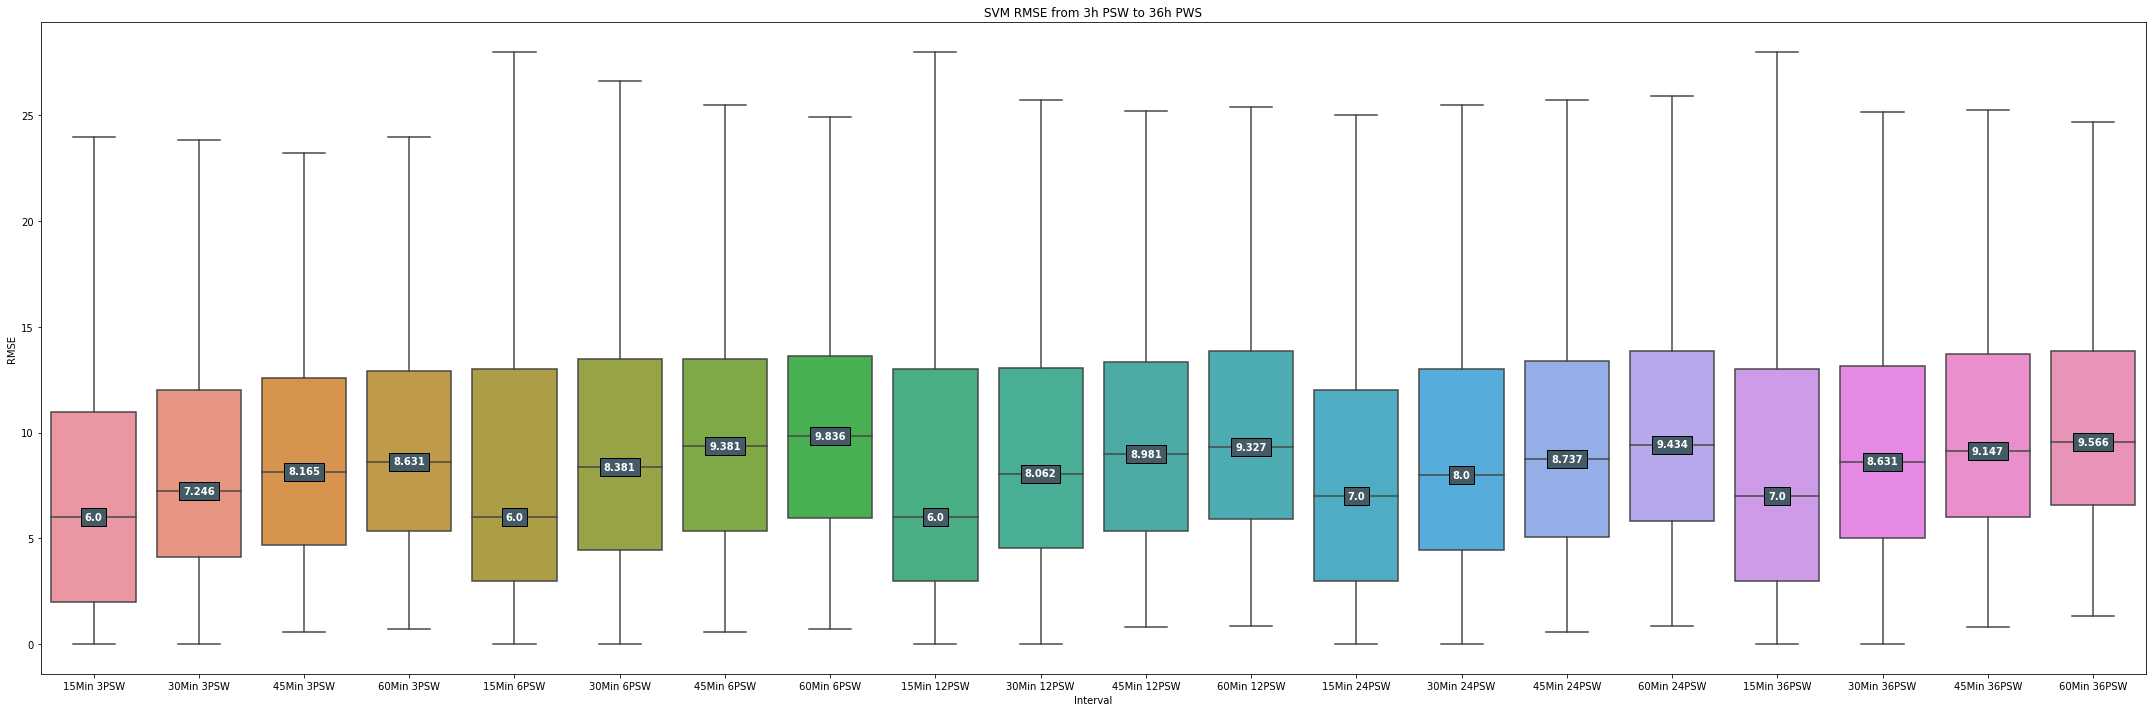

In [211]:
plt.figure(figsize=(30, 10))
plt.title("SVM RMSE from 3h PSW to 36h PWS")
plt.ylabel("RMSE")
plt.xlabel("")


box_plot = sns.boxplot(x="Interval" ,y="RMSE" ,data=window, showfliers = False)

ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*5].get_ydata()[0],3) 
    
    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))
    

box_plot.figure.tight_layout()